# Rayleigh quotient maximization
We first consider the problem of maximizing the Rayleigh quotient $\frac{x^TAx}{2\|x\|_2^2}$ over $\mathbb{R}^d$, i.e. of finding the dominant eigenvector of $A\in\mathbb{R}^{d\times d}$.

This non-convex problem can be written on the open hemisphere $\mathbb{S}^{d-1}$ and is known to be geodesically gradient-dominated.

In [116]:
#libraries to import
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt 
from utils import random_psd
from geometric_optimizers import RGD_optimizer, RAGD_optimizer,RAGDsDR_optimizer
from pymanopt.manifolds import Sphere
import torch
import time
%config InlineBackend.figure_format = 'svg'

### Hyperparameters for problem definition and solution

In [117]:
# problem hyperparameters
seed = 109 #for reproducibility
d = 2000 #problem dimension
n = int(1.05*d) # if n~=d, problem is hard

# algorithm hyperparameters
N = 500 #number of iterations for optimizers
line_search_iterations = 8

### Problem definition and numerical solution

In [118]:
## Problem definition & analytic solution
np.random.seed(seed)
A = np.random.randn(d,n)/np.sqrt(n)
H = np.dot(A,A.T)
eigenvalues, eigenvectors = la.eig(H)
max_eig = np.max(eigenvalues)
min_eig = np.min(eigenvalues)
print('Computing numerical solution...')
x_sol = eigenvectors[:, np.argmax(eigenvalues)]/la.norm(eigenvectors[:, np.argmax(eigenvalues)])

Computing numerical solution...


### Manifold initialization

In [119]:
#Manifold functions
M = Sphere(d)

def cost(X):return -0.5*np.dot(X,np.dot(H, X))
def egrad(X):return -np.dot(H,X)
def grad(X):return M.egrad2rgrad(X,egrad(X))
def retr(X):return M.retr(X,0*X)
def exp(X,U):return M.exp(X,U)
def rexp(X,U):return retr(M.exp(X,U)) #more stable than just exp!!
def log(X,Y):return M.log(X,Y)
def dist(X,Y):return M.dist(X,Y)
def transp(X,Y,U):return M.transp(X,Y,U)

### Optimization  

In [120]:
# iterations to solve
mu = min_eig #for Zhang and Sra algorithm
L = max_eig #smoothness modulus
h = 1/L #stepsize
x0=retr(10*np.random.randn(d,)) #starting position

#running the optimizers
t1, x1, f1 = RGD_optimizer(N,x0,L,cost,grad,exp)
t2, x2, f2 = RAGD_optimizer(N,x0,L,mu,cost,grad,exp,log)
t3, x3, f3, beta3 = RAGDsDR_optimizer(N,x0,L,cost,grad,rexp,log,transp,line_search_iterations)
t4, x4, f4, beta4 = RAGDsDR_optimizer(N,x0,L,cost,grad,rexp,log,transp,-1)

Running Riemannian GD...
Running Riemannian AGD (Zhang and Sra)...
Running Riemannian AGDsDR(linesearch)...
Running Riemannian AGDsDR(no linesearch)...


### Plotting the results

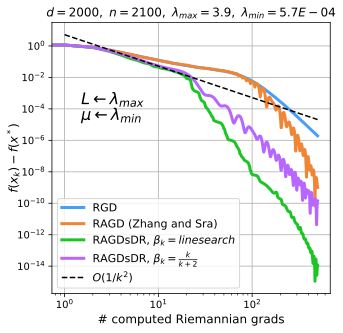

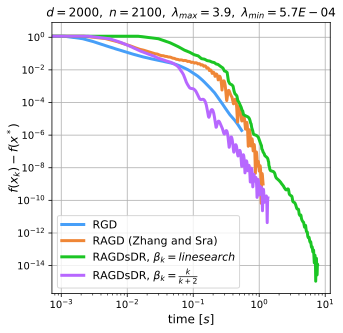

In [123]:
fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(range(N), f1-cost(x_sol),label='RGD',linewidth=3, color = '#479FF8')
ax.loglog(range(N), f2-cost(x_sol),label='RAGD (Zhang and Sra)',linewidth=3, color='#EF8636')
ax.loglog(range(N), f3-cost(x_sol),label=r'RAGDsDR, $\beta_k = linesearch$',linewidth=3, color='#1BC524')
ax.loglog(range(N), f4-cost(x_sol),label=r'RAGDsDR, $\beta_k = \frac{k}{k+2}$',linewidth=3, color='#B767FF')
ax.loglog(range(1,N), 5.2*np.divide(1,np.power(range(1,N),2)),'--',label='$O(1/k^2)$',color='black')
plt.xlabel(r'# computed Riemannian grads',size=12)
plt.ylabel(r'$f(x_k)-f(x^*)$',size=12,labelpad=-3)
plt.title(r'$d = %d, \ n= %d, \ \lambda_{max}=%.1f, \ \lambda_{min}=%.1E$'%(d,n,max_eig,min_eig))
ax.grid()
ax.legend(fontsize=11)
plt.text(1.5, 0.0002, r'$L\leftarrow\lambda_{max}$'%L, size=16)
plt.text(1.5, 0.00002, r'$\mu\leftarrow\lambda_{min}$'%L, size=16)
#ax.set_ylim(bottom=1e-15)
plt.show()
filename='results/RAYLEIGH_iteration_seed'+str(seed)+'_d'+str(d)+'_n'+str(n)+'_L.png'
fig.savefig(filename, format='png', dpi=1000)

fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(t1, f1-cost(x_sol),label='RGD',linewidth=3, color = '#479FF8')
ax.loglog(t2, f2-cost(x_sol),label='RAGD (Zhang and Sra)',linewidth=3, color='#EF8636')
ax.loglog(t3, f3-cost(x_sol),label=r'RAGDsDR, $\beta_k = linesearch$',linewidth=3, color='#1BC524')
ax.loglog(t4, f4-cost(x_sol),label=r'RAGDsDR, $\beta_k = \frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'time $[s]$',size=12)
plt.ylabel(r'$f(x_k)-f(x^*)$',size=12,labelpad=-3)
plt.title(r'$d = %d, \ n= %d, \ \lambda_{max}=%.1f, \ \lambda_{min}=%.1E$'%(d,n,max_eig,min_eig))
ax.grid()
ax.legend(fontsize=11)
#ax.set_ylim(bottom=1e-15)
plt.show()
filename='results/RAYLEIGH_time_seed'+str(seed)+'_d'+str(d)+'_n'+str(n)+'_L.png'
fig.savefig(filename, format='png', dpi=1000)

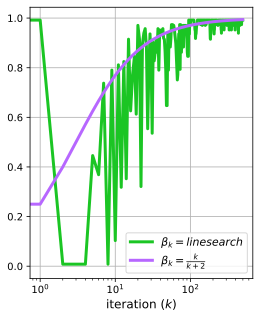

In [125]:
fig, ax = plt.subplots(figsize=(4,5))
ax.semilogx(range(N-2), beta3[0:-2],label=r'$\beta_k=linesearch$',linewidth=3, color='#1BC524')
ax.semilogx(range(N-2), beta4[0:-2],label=r'$\beta_k=\frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'iteration $(k)$',size=12)
ax.grid()
ax.legend(fontsize=11)
plt.show()
filename='results/RAYLEIGH_beta_seed'+str(seed)+'_d'+str(d)+'_n'+str(n)+'.png'
fig.savefig(filename, format='png', dpi=1000)